In [11]:
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
set.seed(1)
options(repr.matrix.max.rows = 10)

In [12]:
players_data<-read_csv("https://raw.githubusercontent.com/lilypurdy/toy_ds_project/refs/heads/main/players%20(2).csv")
head(players_data, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


In [13]:
clean_players_data <- read_csv("https://raw.githubusercontent.com/Jamesnam1/toy_ds_project/refs/heads/main/players.csv",
    col_names = c("experience", "subscribed", "hashed_email", "hours_played", "name", "gender", "age"),
                col_types = list("c", "l", "c", "d", "c", "c", "i"))
clean_players_data

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


experience,subscribed,hashed_email,hours_played,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
experience,NA,hashedEmail,NA,name,gender,NA
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [14]:
players <- clean_players_data |>
  select(-hashed_email, -subscribed, -name, -gender) |>
  filter(!is.na(age)) |>
  filter(hours_played > 0.1)
players

experience,hours_played,age
<chr>,<dbl>,<int>
Pro,30.3,9
Veteran,3.8,17
Amateur,0.7,21
Veteran,1.6,23
Beginner,1.5,25
⋮,⋮,⋮
Pro,0.2,17
Amateur,32.0,22
Pro,1.7,17


In [15]:
set.seed(2)

split_data <- initial_split(players, prop = 3/4, strata = hours_played)

training_data <- training(split_data)
testing_data <- testing(split_data)

head(training_data)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


experience,hours_played,age
<chr>,<dbl>,<int>
Amateur,0.2,22
Amateur,0.5,17
Regular,0.6,19
Beginner,0.6,26
Veteran,0.4,20
Amateur,0.2,17


In [16]:
set.seed(2)

data_recipe <- recipe(hours_played ~ age, data = training_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

data_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

data_vfold <- vfold_cv(training_data, v = 5, strata = hours_played)

data_wkflw <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(data_spec)

data_wkflw

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [17]:
set.seed(2)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

data_results <- data_wkflw |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

data_results

→ A | warning: 46 samples were requested but there were 44 rows in the data. 39 will be used.

There were issues with some computations   A: x1

→ B | warning: 46 samples were requested but there were 45 rows in the data. 40 will be used.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x4





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.56929,5,8.336109,Preprocessor1_Model01
6,rmse,standard,20.63755,5,7.850123,Preprocessor1_Model02
11,rmse,standard,19.20547,5,8.169811,Preprocessor1_Model03
16,rmse,standard,19.95435,5,7.662529,Preprocessor1_Model04
21,rmse,standard,19.44909,5,7.832776,Preprocessor1_Model05
26,rmse,standard,18.97222,5,7.992914,Preprocessor1_Model06
31,rmse,standard,18.77687,5,7.967049,Preprocessor1_Model07
36,rmse,standard,18.54633,5,8.014463,Preprocessor1_Model08
41,rmse,standard,18.38991,5,8.082601,Preprocessor1_Model09


In [18]:
# show only the row of minimum RMSPE
set.seed(2)

data_min <- data_results |>
  filter(mean == min(mean))

data_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,18.38991,5,8.082601,Preprocessor1_Model09


In [19]:
kmin <- data_min |> pull(neighbors)

# Define model specification with best K
sacr_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

# Fit the model
data_fit <- workflow() |>
  add_recipe(data_recipe) |>
  add_model(sacr_spec) |>
  fit(data = training_data)

# Predict and evaluate RMSE
data_summary <- data_fit |>
  predict(testing_data) |>
  bind_cols(testing_data) |>
  metrics(truth = hours_played, estimate = .pred) |>
  filter(.metric == "rmse")

data_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,76.02733


In [21]:
set.seed(2)


# Create prediction grid over age range
age_prediction_grid <- tibble(
  age = seq(
    from = players |> select(age) |> min(),
    to = players |> select(age) |> max(),
      by= 10
  )
)


age_prediction_grid

age
<dbl>
8
18
28
38
48


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


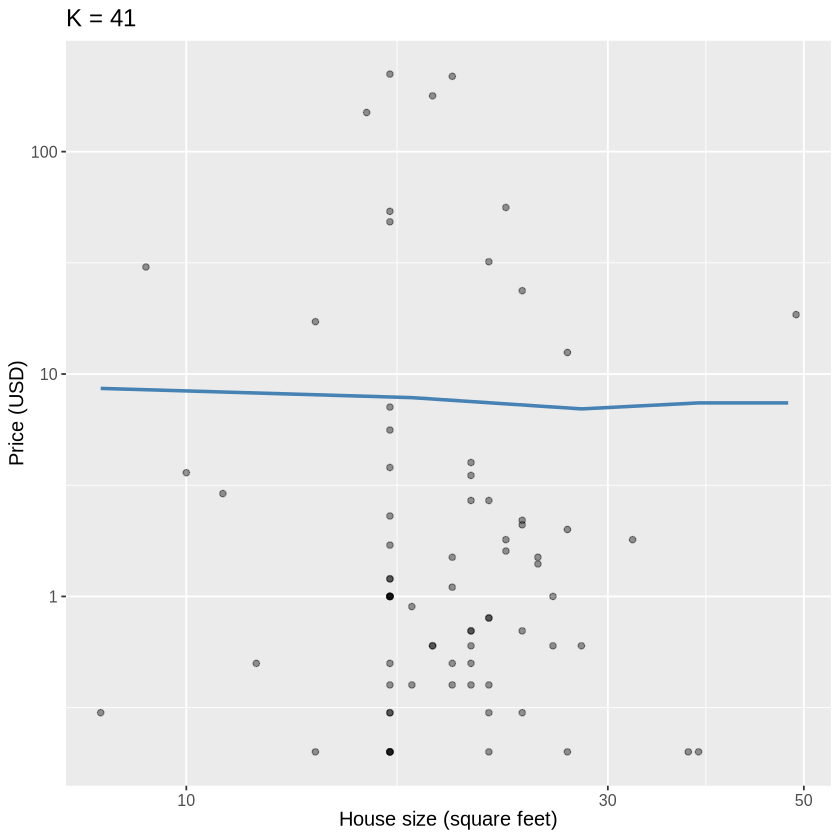

In [23]:

data_preds <- data_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

plot_final <- ggplot(players, aes(x = age, y = hours_played)) +
  geom_point(alpha = 0.4) +
  geom_line(data = data_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("House size (square feet)") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  ggtitle(paste0("K = ", kmin)) +
     scale_y_log10(labels=comma)+
     scale_x_log10(labels=comma)+
  theme(text = element_text(size = 12))

plot_final